In [27]:
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
data = pd.read_excel(r"C:\Users\DELL\Online Retail.xlsx")

In [3]:
print(data.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [4]:
print(data.head()) 

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [5]:
data.isnull().sum() 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data = data.dropna(subset=['CustomerID'])

In [7]:
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [9]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [12]:
reference_date = data['InvoiceDate'].max()

In [13]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [14]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

In [15]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

In [16]:
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12347.0           1        182   4310.00
12348.0          74         31   1797.24
12349.0          18         73   1757.55
12350.0         309         17    334.40


In [18]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  
rfm_pca = pca.fit_transform(rfm_scaled)
rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PCA1', 'PCA2'])

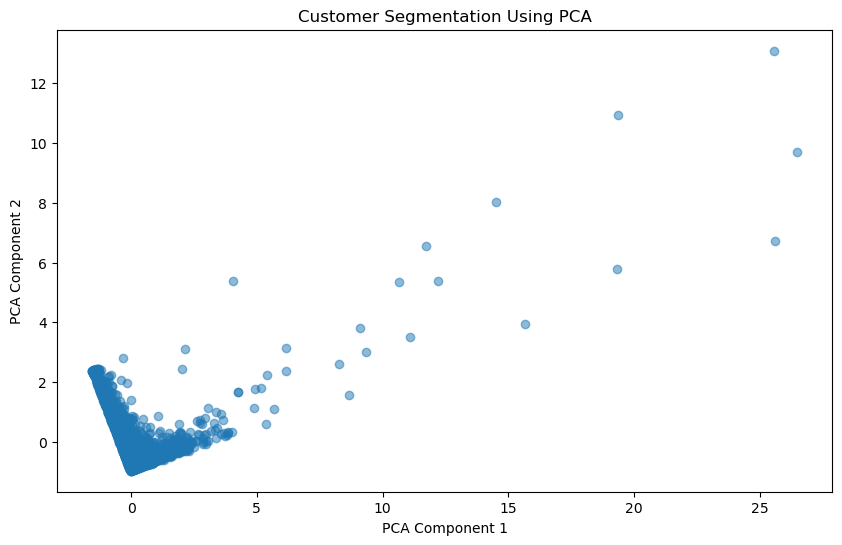

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(rfm_pca_df['PCA1'], rfm_pca_df['PCA2'], alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segmentation Using PCA')
plt.show()

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_k

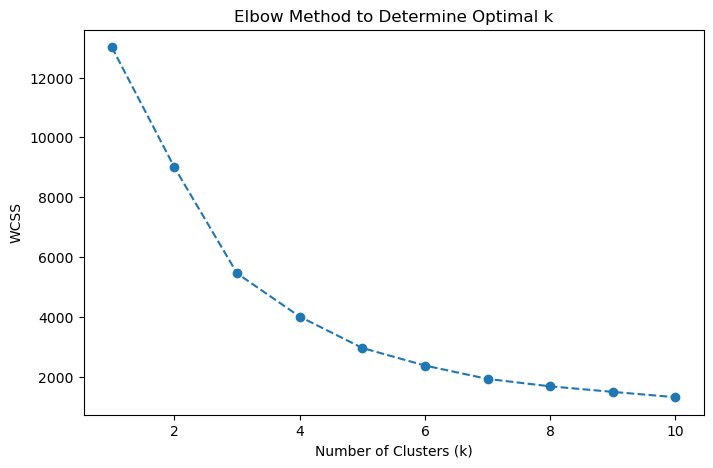

In [23]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [25]:
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(rfm_scaled)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
silhouette_avg = silhouette_score(rfm_scaled, labels)
print(f'Silhouette Score for k={optimal_k}: {silhouette_avg:.2f}')

Silhouette Score for k=3: 0.60


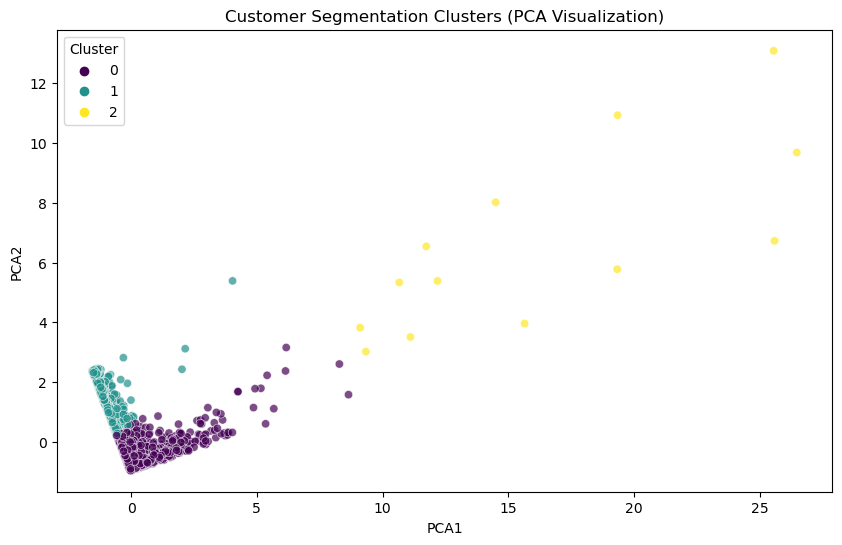

In [28]:
rfm_pca_df['Cluster'] = labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm_pca_df, palette='viridis', alpha=0.7)
plt.title('Customer Segmentation Clusters (PCA Visualization)')
plt.show()